In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


## Load the dataset


In [3]:
df = pd.read_csv("Arima_Rathnapura.csv", parse_dates=['Month'], index_col=['Month'])
ts = df['Production/Kg'].resample('MS').sum()

## Plot the time series data


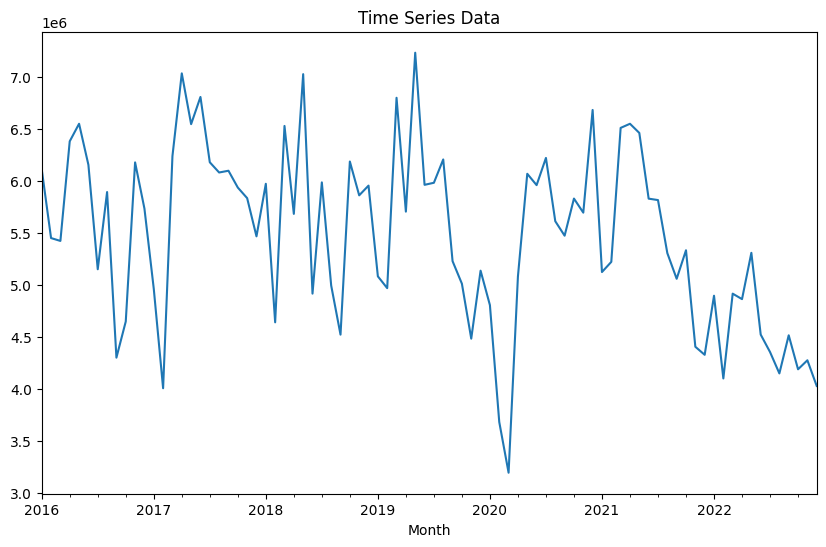

In [4]:
plt.figure(figsize=(10, 6))
ts.plot()
plt.title('Time Series Data')
plt.show()

## ADFuller test to check for stationarity


In [8]:
adf_test = adfuller(ts)
print('p-value of ADFuller test is:', adf_test[1])

# If the series is not stationary, difference it
if adf_test[1] > 0.05:
    ts_diff = ts.diff().dropna()
else:
    ts_diff = ts

p-value of ADFuller test is: 0.11068006675718123


## Decompose the time series to observe trends and seasonality


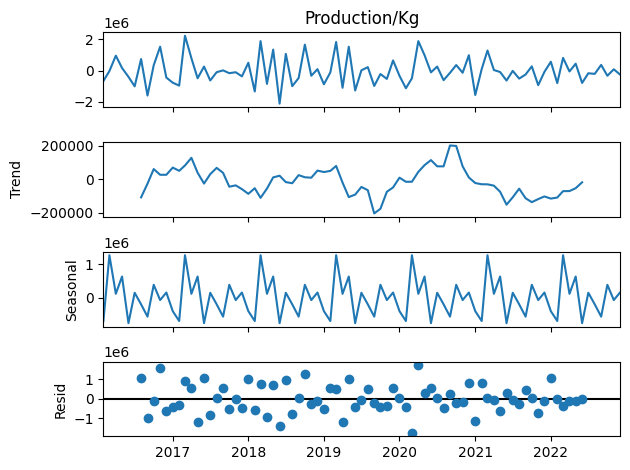

In [9]:
decomposition = sm.tsa.seasonal_decompose(ts_diff, model='additive')
fig = decomposition.plot()
plt.show()


## Scale the data


In [11]:
scaler = StandardScaler()
ts_scaled = scaler.fit_transform(ts_diff.values.reshape(-1, 1))

## Convert scaled data back to series


In [12]:
ts_scaled = pd.Series(ts_scaled.flatten(), index=ts_diff.index)


## Split the data into training and testing sets


In [14]:
train_size = int(len(ts_scaled) * 0.8)
train, test = ts_scaled[:train_size], ts_scaled[train_size:]

## Fit the ARIMA model - using grid search to find optimal parameters


In [15]:
best_aic = np.inf
best_order = None
best_mdl = None
pq_rng = range(3)
d_rng = range(2)
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = ARIMA(train, order=(i, d, j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except:
                continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')


C:\Users\RANASINGHE\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\RANASINGHE\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\RANASINGHE\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\RANASINGHE\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using 

Best ARIMA order: (1, 0, 1) with AIC: 182.5968183280668


## Fit the best ARIMA model


In [16]:
model = ARIMA(train, order=best_order).fit()


## Make predictions


In [17]:
pred = model.predict(start=len(train), end=len(train) + len(test) - 1)


## Evaluate the model


In [18]:
mse = mean_squared_error(test, pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.31319223130990037


## Inverse transform the predictions and test data to original scale


In [19]:
pred_inv = scaler.inverse_transform(pred.values.reshape(-1, 1)).flatten()
test_inv = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()


## Ensure equal lengths for plotting


In [21]:
if len(test_inv) != len(ts.index[train_size:]):
    print("Warning: Length mismatch between test_inv and ts.index[train_size:]")
    # You might need to adjust the code based on the specific reason for the mismatch
    # For example, you could truncate or pad one of the arrays



In [25]:
pred_inv = scaler.inverse_transform(pred.values.reshape(-1, 1)).flatten()
test_inv = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()

In [26]:
plt.figure(figsize=(10, 6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

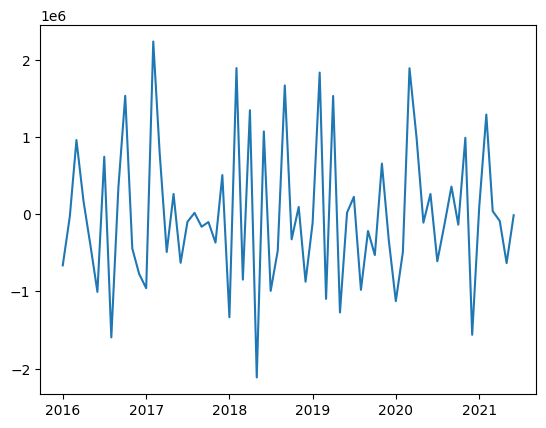

In [27]:
plt.plot(ts.index[:train_size], scaler.inverse_transform(train.values.reshape(-1, 1)).flatten(), label='Training Data')


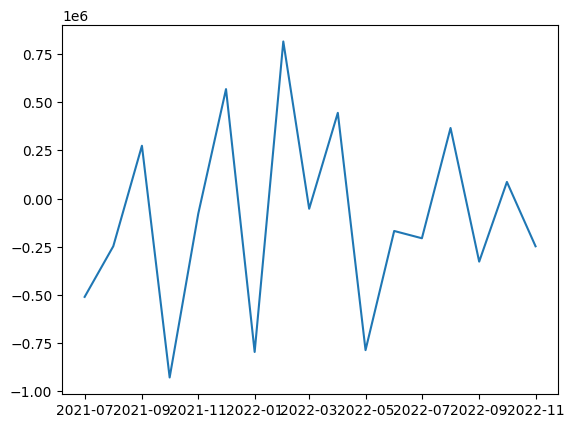

In [28]:
plt.plot(ts.index[train_size:train_size+len(test_inv)], test_inv, label='Actual Data')


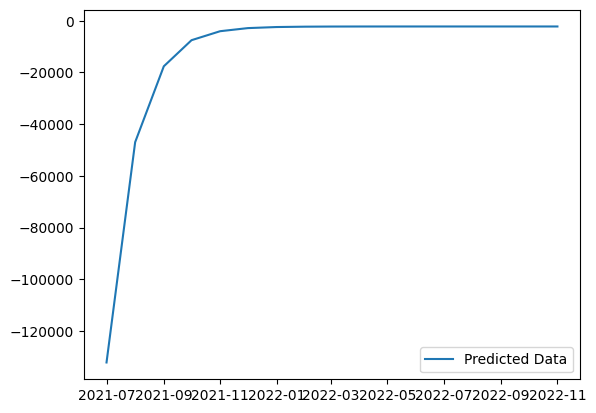

In [31]:
plt.plot(ts.index[train_size:train_size+len(pred_inv)], pred_inv, label='Predicted Data')
plt.legend()
plt.show()


In [32]:
future_pred = model.predict(start=len(ts_scaled), end=len(ts_scaled)+11)
future_pred_inv = scaler.inverse_transform(future_pred.values.reshape(-1, 1)).flatten()

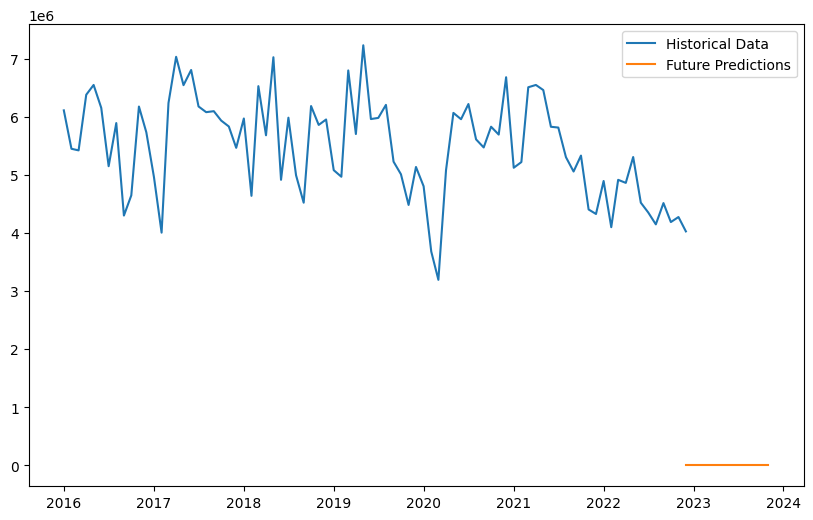

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Historical Data')

future_dates = pd.date_range(start=ts.index[-1], periods=12, freq='MS')
plt.plot(future_dates, future_pred_inv, label='Future Predictions')
plt.legend()
plt.show()


In [34]:
print(future_pred_inv)


[-2238.2991516  -2238.29800971 -2238.29761659 -2238.29748126
 -2238.29743466 -2238.29741862 -2238.2974131  -2238.2974112
 -2238.29741055 -2238.29741032 -2238.29741024 -2238.29741022]


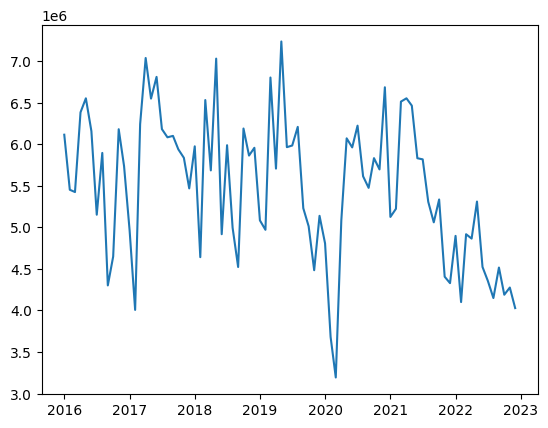

In [38]:
plt.plot(ts.index, ts, label='Historical Data')


In [40]:
future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')


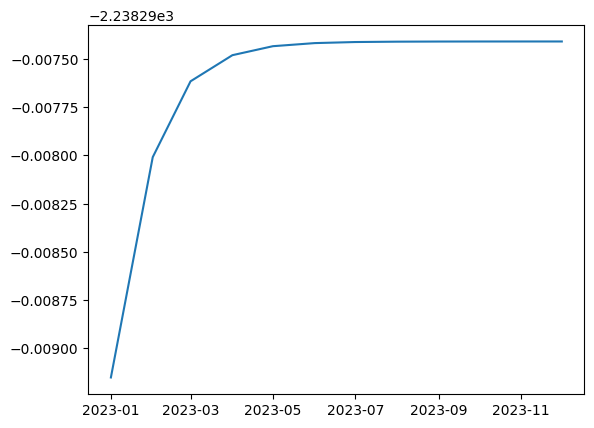

In [41]:
plt.plot(future_dates, future_pred_inv, label='Future Predictions')
